## Denoising images with ML techniques:

### Relevant imports and provided functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from functools import partial
from scipy.misc import imread, imsave


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def neighbours(i, j, M, N, size=4):
    candidates = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    if size == 8:
        candidates.extend([(i-1, j-1), (i-1, j+1), (i+1, j+1), (i+1, j-1)])
    
    valid_points = [(i, j) for (i, j) in candidates if i >= 0 and i < M and j >= 0 and j < N]
    return valid_points

### Defining the hyperparameters, prior, likelihood and joint likelihood:

In [2]:
def initialise_W(shape, scaling_factor):
    """
    shape is a tuple with the dimensions of the image
    scaling_factor is a number controlling the scale of the weights
    returns a list of a list of numpy matrixes, with a matrix being the W hyperparameters
    for the weights of the neighnours of a given pixel
    """
    def initialise_W_ij(i, j, scaling_factor):
        """
        i and j are the coordinates of the pixel
        scaling_factor is a number controlling the scale of the weights
        returns a numpy matrix W being the hyperparameters of the weights for the neighbours of the pixel
        """
        W = np.ones(shape=(3, 3), dtype=np.float32)  # Set all weights to 1
        W *= scaling_factor # Rescale to get reasonable value of the prior
        return W
        
    matrixes = []
    M, N = shape
    for row in range(0, M):
        row_list = []
        for col in range(0, N):
            W_row_col = initialise_W_ij(row, col, scaling_factor)
            row_list.append(W_row_col)
        matrixes.append(row_list)
    return matrixes

def initialise_x(y):
    """
    Currently initialises x to a black rectange inside a white rectangle
    y is a numpy matrix with the observed values
    returns a numpy matrix with the initialised values for x
    """
    x = np.zeros(shape=y.shape, dtype=np.int8)
    M, N = y.shape
    
    inner_height = int(M/math.sqrt(2))
    inner_width = int(N/math.sqrt(2))
    inner_height_margin = int((M-inner_height)/2)
    inner_width_margin = int((N-inner_width)/2)
    for row in range(0, M):
        for col in range(0, N):
            inner_row = row >= inner_height_margin and row <= inner_height_margin+inner_height
            inner_col = col >= inner_width_margin and col <= inner_width_margin+inner_width
            if inner_row and inner_col:
                # It is part of the inner rectange
                x[row, col] = -1
            else:
                # It is part of outter rectangle
                x[row, col] = 1
    return x

def prior(x, W, size=4, compute_only=[]):
    """
    x is a numpy matrix for the latent variables x
    W is a list of a list of numpy matrixes being hyperparameters of the weights for the neighbours of a pixel
    size is an integer, either 4 or 8, being a hyperparameter for the size of the neighbourhood of a pixel
    compute_only is an optional list of (int, int) with the pixels to compute the prior over only
    """
    def E(x, W, size, row, col):
        """
        x is a numpy matrix for the latent variables x
        W is a list of a list of numpy matrixes being hyperparameters for the weights of the neighbours of a pixel
        size is an integer, either 4 or 8, being a hyperparameter for the size of the neighbourhood of a pixel
        row and col are integers for the coords of the pixel x_i
        returns a number - the likelihood of the parameter x_i given the hyperparameters
        """
        M, N = x.shape
        E_i = 0
        x_i = x[row, col]
        neighbour_list = neighbours(row, col, M, N, size)
        for neighbour_row, neighbour_col in neighbour_list:
            W_row, W_col = neighbour_row-row+1, neighbour_col-col+1
            W_ij = W[row][col][W_row, W_col]
            x_j = x[neighbour_row, neighbour_col]
            E_i += W_ij*x_i*x_j
        return E_i 
    
    E_0 = 0
    if len(compute_only) > 0:
        # Compute over this list of pixels only
        for row, col in compute_only:
            E_i = E(x, W, size, row, col)
            E_0 += E_i
    else:
        # Compute over all the pixels
        M, N = x.shape
        for row in range(0, M):
            for col in range(0, N):
                E_i = E(x, W, size, row, col)
                E_0 += E_i
    
    #print("E_0 is: {}".format(E_0))
    return math.e ** E_0

def L_i(i, j, x_i, y_i, scaling_factor):
    """
    i and j are the coordinates of the pixel
    x_i is the value of the latent variable at coords (i, j)
    y_i is the observed pixel value at coords (i, j)
    scaling_factor is a hyperparameter regulating the scale of the function values
    returns the likelihood of y being generated by x
    """
    likelihood = 0
    if x_i == 1:
        likelihood = y_i + 1
    elif x_i == -1:
        likelihood = 1 - y_i + 1
    return likelihood * scaling_factor

def likelihood(y, x, scaling_factor, compute_only=[]):
    """
    x and y are numpy matrixes
    scaling_factor is a hyperparameter for the L_i function
    compute_only is an optional list of (int, int) with the pixels to compute the likelihood over only
    Returns the likelihood of y given x
    """
    likelihood = 1
    if len(compute_only) > 0:
        for row, col in compute_only:
            x_i = x[row, col]
            y_i = y[row, col]
            likelihood_i = math.e ** L_i(row, col, x_i, y_i, scaling_factor)
            likelihood *= likelihood_i
    else:
        M, N = x.shape
        for row in range(0, M):
            for col in range(0, N):
                x_i = x[row, col]
                y_i = y[row, col]
                likelihood_i = math.e ** L_i(row, col, x_i, y_i, scaling_factor)
                likelihood *= likelihood_i
    return likelihood

def joint_likelihood(x, y, neighbourhood_size, likelihood_scaling_factor, W):
    """
    x and y are numpy matrixes, x being the latent variables and y the observed variables
    likelihood_scaling_factor is a hyperparameter for the likelihood function
    neighbourhood_size is the size of the neighbourhood for a given pixel
    W are the hyperparameters for the prior function
    returns the joing likelihood of x and y
    """
    prior_val = prior(x, W, neighbourhood_size)
    likelihood_val = likelihood(y, x, likelihood_scaling_factor)
    #print("prior: {:.4f}, likelihood: {:.4f}".format(prior_val, likelihood_val))
    #print("Prior likelihood is: {}".format(prior_val))
    #print("Likelihood is: {}".format(likelihood_val))
    return prior_val * likelihood_val


### Implementing the ICM algorithm below:

In [3]:
def ICM(y, p, T):
    """
    y is a numpy matrix with the observed values
    p is as function of the form p(x, y) which computes the joint likelihood
    T is the number of maximum iterations to perform
    returns a numpy matrix being an estimate of x, the latent variables
    """    
    x = initialise_x(y)
    x_new = np.zeros(shape=y.shape, dtype=np.int8)
    M, N = y.shape
    for t in range(0, T):
        print("Doing iteration {}".format(t))
        start_time = time.time()
        for row in range(0, M):
            for col in range(0, N):
                x_ij = x[row, col]
                # Set x_ij to 1 and find likelihood
                x[row, col] = 1
                one_likelihood = p(x, y)
                # Set x_ij to -1 and find likelihood
                x[row, col] = -1
                minus_one_likelihood = p(x, y)
                x[row, col] = x_ij  # Restoring the true value
                if one_likelihood > minus_one_likelihood:
                    x_new[row, col] = 1
                else:
                    x_new[row, col] = -1
        elapsed_time = time.time() - start_time
        print("Iteration took {:.3f}sec.".format(elapsed_time))
        # Swap arrays for memory reuse
        temp = x
        x = x_new
        x_new = temp
        # Now if no changes have been made, stop looping
        if np.array_equal(x, x_new):
            break
    print("ICM done after {} iterations".format(t))
    return x  

### Implementing the Gibbs sampling with optional random node iteration below:

In [4]:
def gibbs_sampling(y, T, neighbourhood_size, likelihood_func, prior_func, random_order=False):
    """
    y is a numpy matrix being the observed noisy image
    T is the number of maximum iterations to perform
    neighbourhood_size is either 4 or 8
    likelihood_func is a function of the form f(y, x, scaling_factor, compute_only=[]) to compute the likelihood
    prior_func is a function of the form f(x, size=4, compute_only=[]) to compute the prior
    random_order set to True makes the algorithm randomly process pixels
    returns a numpy matrix being the recovered latent variables x
    """
    def posterior(x, y, row, col, neighbourhood_size, likelihood_func, prior_func):
        """
        x is a numpy matrix being the current estimation of the latent variables x
        y is a numpy matrix being the observed noisy image
        row and col are the integer coordinates of pixel x_i
        neighbourhood_size is either 4 or 8
        likelihood_func is a function of the form f(y, x, compute_only=[]) to compute the likelihood
        prior_func is a function of the form f(x, size=4, compute_only=[]) to compute the prior
        Calculates the posterior for pixel x_i with coords (row, col)
        """
        list_just_x_i = [(row, col)]
        list_x_i_and_neighbours = neighbours(row, col, M, N, neighbourhood_size) + [(row, col)]
        x_i = x[row, col]  # Retain current value
        x[row, col] = 1  # Set temporarily to 1
        likelihood_one_val = likelihood_func(y=y, x=x, compute_only=list_just_x_i)
        prior_one_val = prior_func(x=x, size=neighbourhood_size, compute_only=list_x_i_and_neighbours)
        x[row, col] = -1  # Set temporarily to -1
        likelihood_minus_one_val = likelihood_func(y=y, x=x, compute_only=list_just_x_i)
        prior_minus_one_val = prior_func(x=x, size=neighbourhood_size, compute_only=list_x_i_and_neighbours)
        nominator = likelihood_one_val*prior_one_val
        denominator = likelihood_one_val*prior_one_val + likelihood_minus_one_val*prior_minus_one_val
        posterior_val = nominator/denominator
        #print("p1 {:0.4f}, l1 {:0.4f}, p-1 {:0.4f}, l-1 {:0.4f}, n {:0.4f}, d {:0.4f}, posterior: {:0.4f}".format(
            #prior_one_val, likelihood_one_val, prior_minus_one_val, likelihood_minus_one_val,
            #nominator, denominator, posterior_val))
        x[row, col] = x_i  # Restore the original value
        return posterior_val
    
    x = initialise_x(y)
    M, N = y.shape
    np.random.seed(42)  # In case we want to sample randomly
    for r in range(0, T):
        #print("Doing iteration {}".format(r))
        start_time = time.time()
        for row in range(0, M):
            for col in range(0, N):
                # Calculating the posterior
                pixel_row = row
                pixel_col = col
                # If random_order is True, draw random pixel coords to process
                if random_order is True:
                    pixel_row, pixel_col = np.random.randint(0, M), np.random.randint(0, N)
                p_i = posterior(x, y, row, col, neighbourhood_size, likelihood_func, prior_func)
                t = np.random.uniform(low=0, high=1) # Uniform distribution sample
                if p_i > t:
                    x[row, col] = 1
                else:
                    x[row, col] = -1
        elapsed_time = time.time() - start_time
        if r % 50 == 0:
            print("Iteration {} took {:.3}sec.".format(r, elapsed_time))
    print("Gibbs sampling done after {} iterations".format(r))
    return x

### Questions 6-7. Implementing the Variational Bayes for the Ising model below:

In [5]:
def initialise_mu(y):
    """
    y is a numpy matrix with the observed variables y
    return a matrix with the initialised variables mu_i
    """
    M, N = y.shape[0], y.shape[1]
    mu = np.zeros(shape=(M, N), dtype=np.float32)
    return mu

def variational_bayes(y, T, W, L_i_func, neighbours_func):
    """
    y is a numpy matrix with the observed variables y
    T is an integer for the number of iterations
    W is a list of a list of numpy matrixes being the weights for the i_j pixel relationship
    L_i_func is a function returning a large variable if x_i is likely to have generated y_i
    neighbours_func is a function that returns a list of neighbours for a given pixel
    returns a numpy matrix with the parameters mu of the distribution q(X)
    """
    mu = initialise_mu(y)
    mu_prime = np.zeros(shape=mu.shape, dtype=np.float32)
    M, N = y.shape
    for t in range(0, T):
        start_time = time.time()
        for row in range(0, M):
            for col in range(0, N):
                # Compute m_i^(t+1)
                W_i = W[row][col]
                N_i = neighbours_func(row, col, M, N)
                m_i = 0
                # Compute the sum
                for neighbour_row, neighbour_col in N_i:
                    W_row, W_col = neighbour_row-row+1, neighbour_col-col+1
                    W_i_j = W_i[W_row, W_col]
                    mu_j = mu[neighbour_row, neighbour_col]
                    m_i += W_i_j*mu_j
                # Now, compute the variational parameter mu_i
                y_i = y[row][col]
                L_i_one = L_i_func(i=row, j=col, x_i=1, y_i=y_i)
                L_i_minus_one = L_i_func(i=row, j=col, x_i=-1, y_i=y_i)
                mu_prime[row, col] = math.tanh(m_i + 1.0/2*(L_i_one - L_i_minus_one))
        elapsed_time = time.time() - start_time
        if t % 2 == 0:
            print("Iteration {} took {:.3}sec.".format(t, elapsed_time))
        # Swap variables
        temp = mu
        mu = mu_prime
        mu_prime = temp
    
    return mu  # The parameters for q(X)

### Implementing the image segmentation of coloured images below:

In [6]:
def get_image_masks(image):
    """
    foreground will be a rectangle with half the image size centered around the image center
    image is a 3D matrix of a coloured image
    returns a tuple of foreground and background masks, each being a matrix of booleans
    """
    M, N, _ = image.shape
    foreground_height = int(M/math.sqrt(2))
    foreground_width = int(N/math.sqrt(2))
    foreground_height_margin = int((M-foreground_height)/2)
    foreground_width_margin = int((N-foreground_width)/2)
    foreground = np.zeros(shape=(M, N), dtype=np.bool)
    background = np.zeros(shape=(M, N), dtype=np.bool)
    for row in range(0, M):
        for col in range(0, N):
            foreground_row = row >= foreground_height_margin and row <= foreground_height_margin+foreground_height
            foreground_col = col >= foreground_width_margin and col <= foreground_width_margin+foreground_width
            if foreground_row and foreground_col:
                # It is part of the foreground
                foreground[row, col] = True
            else:
                # It is part of the background
                background[row, col] = True
    
    return foreground, background

def get_mask_histogram(image, mask, bins):
    """
    image is a 3D numpy array of a coloured image
    mask is a 2D numpy array with boolean values, indicating membership in the mask
    bins is an integer in the range [1, 255], being the number of bins for the histogram
    returns a 1D numpy array with the probability densities of the bins of the normalised histogram
    """
    mean_intensities = image.mean(axis=2, dtype=np.int16)  # Compute the pixel mean intensity of RGB values
    mask_pixel_intensities = mean_intensities[mask]  # Flattened array with intensities of mask pixels
    # Now get an array with a PDF value for every bin of the normalised histogram
    histogram, bin_edges = np.histogram(mask_pixel_intensities, bins=bins, range=(0, 255), density=True)
    return histogram

def histogram_likelihood(image, row, col, is_foreground, histograms, scaling_factor, bins):
    """
    Computes the likelihood of the pixel image[row, col] given the mask it belongs to
    image is a 3D numpy array if a coloured image
    row and col are a given pixel's coordinates in the image
    is_foreground is a boolean value indicating mask membership
    histograms is a tuple of numpy arrays with the probability densities for each histogram bin
    scaling_factor is a scaling hyperparameter
    bins is a hyperparameter for the number of bins in the histograms
    returns the likelihood of observing the pixel image[row, col] given its mask membership
    """
    foreground_histogram, background_histogram = histograms
    pixel_intensity = image[row, col].mean()
    pixels_per_bin = 255.0/bins
    bin_index = int(pixel_intensity/pixels_per_bin)
    if bin_index == bins:
        # Edge case for end bin_edge, i.e for pixel intensity 255
        bin_index = bins-1
    
    #print("Pixel intensity: {}, bin index: {}".format(pixel_intensity, bin_index))
    pixel_pdf = 0
    if is_foreground:
        pixel_pdf = foreground_histogram[bin_index]
    else:
        pixel_pdf = background_histogram[bin_index]
    return pixel_pdf*scaling_factor

def image_segmentation_with_variational_bayes(y, T, W, L_i_func, neighbours_func, bins):
    """
    use Variational Bayes for foreground/background image segmentation
    y is a 3D numpy array with the observed variables y
    T is an integer for the number of iterations
    W is a list of a list of numpy matrixes being the weights for the i_j pixel relationship
    L_i_func is a function returning the likelihood of y_i given x_i
    neighbours_func is a function that returns a list of neighbours for a given pixel
    bins is a hyperparameter for the number of bins in the histograms
    returns a numpy matrix with the parameters mu of the distribution q(X)
    """
    foreground, background = get_image_masks(y)
    foreground_histogram = get_mask_histogram(y, foreground, bins)
    background_histogram = get_mask_histogram(y, background, bins)
    print("foreground histogram densities: {}".format(foreground_histogram))
    print("background histogram densities: {}".format(background_histogram))
    histograms = foreground_histogram, background_histogram
    mu = initialise_mu(y)
    mu_prime = np.zeros(shape=mu.shape, dtype=np.float32)
    M, N, _ = y.shape
    for t in range(0, T):
        start_time = time.time()
        for row in range(0, M):
            for col in range(0, N):
                # Compute m_i^(t+1)
                W_i = W[row][col]
                N_i = neighbours_func(row, col, M, N)
                m_i = 0
                # Compute the sum
                for neighbour_row, neighbour_col in N_i:
                    W_row, W_col = neighbour_row-row+1, neighbour_col-col+1
                    W_i_j = W_i[W_row, W_col]
                    mu_j = mu[neighbour_row, neighbour_col]
                    m_i += W_i_j*mu_j
                # Now, compute the variational parameter mu_i
                L_i_one = L_i_func(image=y, row=row, col=col, is_foreground=True, histograms=histograms, bins=bins)
                L_i_minus_one = L_i_func(image=y, row=row, col=col, is_foreground=False, histograms=histograms, bins=bins)
                mu_prime[row, col] = math.tanh(m_i + 1.0/2*(L_i_one - L_i_minus_one))
        elapsed_time = time.time() - start_time
        if t % 2 == 0:
            print("Iteration {} took {:.3}sec.".format(t, elapsed_time))
        # Swap variables
        temp = mu
        mu = mu_prime
        mu_prime = temp
    
    return mu  # The parameters for q(X)

# Main entry for defining the hyperparameters and executing the algorithms:

Running the Variational Bayes for Ising model:
Input image shape: (99, 128)
Plotting true x, gaussian y and salt-peppered y:


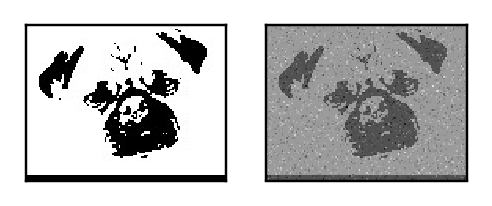

Iteration 0 took 0.33sec.
Iteration 2 took 0.545sec.
Iteration 4 took 0.309sec.
Iteration 6 took 0.274sec.
Iteration 8 took 0.281sec.
Iteration 10 took 0.268sec.
Iteration 12 took 0.267sec.
Iteration 14 took 0.263sec.
Iteration 16 took 0.266sec.
Iteration 18 took 0.318sec.
Iteration 20 took 0.262sec.
Iteration 22 took 0.27sec.
Iteration 24 took 0.268sec.
Iteration 26 took 0.266sec.
Iteration 28 took 0.263sec.
Iteration 30 took 0.27sec.
Iteration 32 took 0.27sec.
Iteration 34 took 0.272sec.
Iteration 36 took 0.272sec.
Iteration 38 took 0.276sec.

Plotting the initial x' and the recovered image:


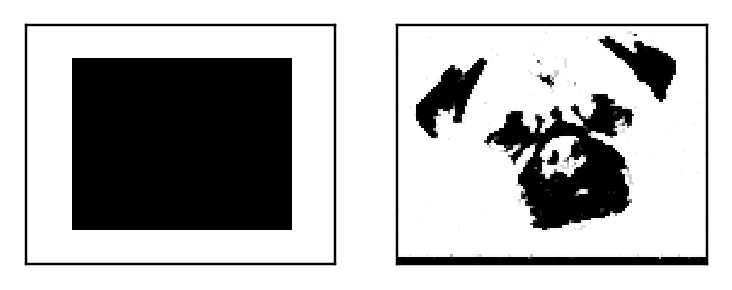

Running the image segmentation:
Input image shape: (465, 600, 3)
Plotting input image to be segmented:


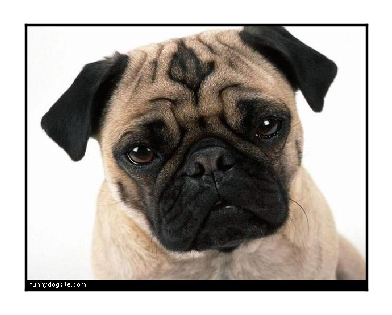

foreground histogram densities: [ 0.00529979  0.00254335]
background histogram densities: [ 0.00171098  0.00613216]
Iteration 0 took 14.1sec.
Iteration 2 took 14.0sec.
Iteration 4 took 13.9sec.
Iteration 6 took 14.3sec.
Iteration 8 took 24.4sec.
Image segmentation done.

Plotting the foreground mask and the generated input image segmentation:


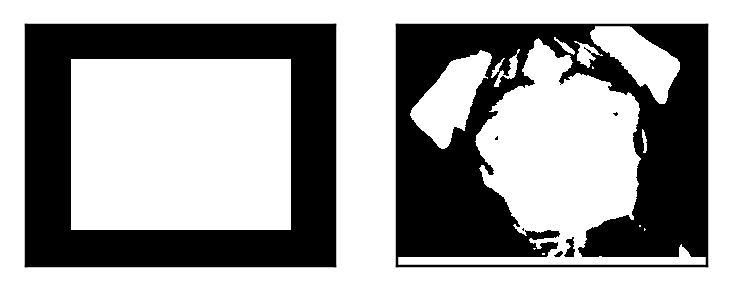

In [18]:
def hide_ticks(axis):
    """
    Utility function that hides axes ticks
    """
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    return axis

def do_icm():
    # Generating noisy input y
    prop = 0.3 # proportion of pixels to alter
    varSigma = 0.1
    image_path = "pugs/pic1_16.jpg"
    original_img = imread(image_path) / 255  # Convert intensities to [0, 1] interval
    gaussian_img = add_gaussian_noise(original_img, prop, varSigma)
    salt_pepper_img = add_saltnpeppar_noise(original_img, prop)
    print("Input image shape: {}".format(original_img.shape))

    # Defining the hyperparameters
    neighbourhood_size = 8  # 8 or 4
    likelihood_scaling_factor = 0.0011  # A value [0.0010, 0.0021] is good
    W_scaling_factor = 0.00004
    max_iterations = 1  # Max number of iterations
    W = initialise_W(original_img.shape, W_scaling_factor)
    partial_joint = partial(joint_likelihood, neighbourhood_size=neighbourhood_size,
                        likelihood_scaling_factor=likelihood_scaling_factor, W=W)
    
    # Plot inputs
    print("Plotting true x, gaussian y and salt-peppered y:")
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(131))
    ax1.imshow(original_img, cmap='gray')
    ax2 = hide_ticks(fig.add_subplot(132))
    ax2.imshow(gaussian_img, cmap='gray')
    ax3 = hide_ticks(fig.add_subplot(133))
    ax3.imshow(salt_pepper_img, cmap='gray')
    plt.show()
    
    # Running the ICM
    recovered = ICM(gaussian_img, partial_joint, max_iterations).astype(np.float32)
    
    # Now plot result
    print("\nPlotting the initial x' and the recovered image:")
    recovered = (recovered + 1) / 2  # Set values to be 1s and 0s
    initial_x = initialise_x(gaussian_img).astype(np.float32)
    initial_x = (initial_x + 1) / 2  # Set values to be 1s and 0s
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(121))
    ax1.imshow(initial_x, cmap='gray')  # Plotting the initial estimate of x
    ax2 = hide_ticks(fig.add_subplot(122))
    ax2.imshow(recovered, cmap='gray')  # Plotting the recovered result with ICM
    plt.show()
    return recovered

def do_gibbs_sampling():
    # Generating noisy input y
    prop = 0.3 # proportion of pixels to alter
    varSigma = 0.1
    image_path = "pugs/pic1_gray_small.jpg"
    original_img = imread(image_path) / 255  # Convert intensities to [0, 1] interval
    gaussian_img = add_gaussian_noise(original_img, prop, varSigma)
    salt_pepper_img = add_saltnpeppar_noise(original_img, prop)
    print("Input image shape: {}".format(original_img.shape))

    # Defining the hyperparameters
    neighbourhood_size = 8  # 8 or 4
    likelihood_scaling_factor = 2.5
    W_scaling_factor = 0.1
    num_iterations = 2
    random_order = False
    W = initialise_W(original_img.shape, W_scaling_factor)
    partial_likelihood = partial(likelihood, scaling_factor=likelihood_scaling_factor)
    partial_prior = partial(prior, W=W)
    
    # Plot inputs
    print("Plotting true x, gaussian y and salt-peppered y:")
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(131))
    ax1.imshow(original_img, cmap='gray')
    ax2 = hide_ticks(fig.add_subplot(132))
    ax2.imshow(gaussian_img, cmap='gray')
    ax3 = hide_ticks(fig.add_subplot(133))
    ax3.imshow(salt_pepper_img, cmap='gray')
    plt.show()
    
    # Running the Gibbs sampling
    recovered = gibbs_sampling(gaussian_img, num_iterations, neighbourhood_size, partial_likelihood, partial_prior, random_order)
    
    # Now plot result
    print("\nPlotting the initial x' and the recovered image:")
    recovered = (recovered + 1) / 2  # Set values to be 1s and 0s
    initial_x = initialise_x(gaussian_img).astype(np.float32)
    initial_x = (initial_x + 1) / 2  # Set values to be 1s and 0s
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(121))
    ax1.imshow(initial_x, cmap='gray')  # Plotting the initial estimate of x
    ax2 = hide_ticks(fig.add_subplot(122))
    ax2.imshow(recovered, cmap='gray')  # Plotting the recovered result with Gibbs sampling
    plt.show()
    return recovered

def do_variational_bayes():
    # Generating noisy input y
    prop = 0.3 # proportion of pixels to alter
    varSigma = 0.3
    image_path = "pugs/pic1_gray_small.jpg"
    original_img = imread(image_path) / 255  # Convert intensities to [0, 1] interval
    gaussian_img = add_gaussian_noise(original_img, prop, varSigma)
    salt_pepper_img = add_saltnpeppar_noise(original_img, prop)
    print("Input image shape: {}".format(original_img.shape))

    # Defining the hyperparameters
    neighbourhood_size = 8  # 8 or 4
    L_i_scaling_factor = 2.5
    W_scaling_factor = 0.3
    num_iterations = 40
    W = initialise_W(original_img.shape, W_scaling_factor)
    partial_L_i = partial(L_i, scaling_factor=L_i_scaling_factor)
    partial_neighbours_func = partial(neighbours, size=neighbourhood_size)
    
    # Plot inputs
    print("Plotting true x, gaussian y and salt-peppered y:")
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(131))
    ax1.imshow(original_img, cmap='gray')
    ax2 = hide_ticks(fig.add_subplot(132))
    ax2.imshow(gaussian_img, cmap='gray')
    #ax3 = hide_ticks(fig.add_subplot(132))
    #ax3.imshow(salt_pepper_img, cmap='gray')
    plt.show()
    
    # Running the Variational Bayes
    recovered = variational_bayes(gaussian_img, num_iterations, W, partial_L_i, partial_neighbours_func)
    
    # Now plot result
    print("\nPlotting the initial x' and the recovered image:")
    recovered = recovered.astype(np.float32)
    recovered = (recovered + 1) / 2  # Set values to be 1s and 0s
    initial_x = initialise_x(gaussian_img).astype(np.float32)
    initial_x = (initial_x + 1) / 2  # Set values to be 1s and 0s
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(121))
    ax1.imshow(initial_x, cmap='gray')  # Plotting the initial estimate of x
    ax2 = hide_ticks(fig.add_subplot(122))
    ax2.imshow(recovered, cmap='gray')  # Plotting the recovered result with Variational Bayes
    plt.show()
    return recovered

def do_image_segmentation():
    colour_img_path = "pugs/pic1.jpg"
    image = imread(colour_img_path)
    print("Input image shape: {}".format(image.shape))
    
    # Defining the hyperparameters
    neighbourhood_size = 8  # 8 or 4
    L_i_scaling_factor = 10000
    W_scaling_factor = 1000
    num_iterations = 10
    num_bins = 2
    W = initialise_W((image.shape[0], image.shape[1]), W_scaling_factor)
    partial_L_i = partial(histogram_likelihood, scaling_factor=L_i_scaling_factor)
    partial_neighbours_func = partial(neighbours, size=neighbourhood_size)
    
    # Plotting input image
    print("Plotting input image to be segmented:")
    fig = plt.figure(figsize=(2, 2), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(111))
    ax1.imshow(image, cmap='gray')
    plt.show()
    
    # Running the image segmentation algorithm
    recovered = image_segmentation_with_variational_bayes(image, num_iterations, W,
                                                          partial_L_i, partial_neighbours_func, num_bins)
    print("Image segmentation done.\n")
    
    # Now plot stuff
    print("Plotting the foreground mask and the generated input image segmentation:")
    recovered = recovered.astype(np.float32)
    recovered = (recovered + 1) / 2  # Set values to be 1s and 0s
    foreground_mask, _ = get_image_masks(image)
    fig = plt.figure(figsize=(4, 7), dpi=220)
    ax1 = hide_ticks(fig.add_subplot(121))
    ax1.imshow(foreground_mask, cmap='gray')  # Plotting the foreground mask
    ax4 = hide_ticks(fig.add_subplot(122))
    ax4.imshow(recovered, cmap='gray')  # Plotting the generated segmentation
    plt.show()
    return recovered

#print("Running the ICM algorithm:")
#recovered = do_icm()
#print("Running the Gibbs sampling:")
#recovered = do_gibbs_sampling()
print("Running the Variational Bayes for Ising model:")
recovered = do_variational_bayes()
print("Running the image segmentation:")
recovered = do_image_segmentation()